In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=110,
    target_version=black.TargetVersion.PY310,
)

In [2]:
import datetime
import math
import os
import pickle
import re
import sys

sys.path.insert(1, os.path.abspath(".."))


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap

import lysis

pd.reset_option("display.precision")
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [3]:
scenario_type = np.dtype(
    [
        ("descriptor", np.str_, 40),
        ("file_code", np.str_, 40),
        ("forced_unbind", np.float_),
        ("average_bind_time", np.float_),
    ]
)
mechanism_type = np.dtype(
    [("file_code", np.str_, 40), ("descriptor", np.str_, 40), ("executable", np.str_, 40)]
)
run_type = np.dtype(
    [
        ("exp_code", np.str_, 15),
        ("scenario", np.str_, 40),
        ("mechanism", np.str_, 40),
        ("seed", int),
        ("running_time", int),
    ]
)

In [4]:
scenarios = np.array(
    [
        ("10x smaller Kd", "_Kd00020036", 0.5143, 277.8),
        ("Physiological Kd", "", 8.52e-2, 27.8),
        ("10x bigger Kd", "_Kd0236", 5.4e-3, 2.78),
    ],
    dtype=scenario_type,
)
mechanisms = np.array(
    [
        ("_always", "Always bind", "macro_Q2_always_rebind"),
        ("_along", "Diffuse along clot", "macro_Q2_diffuse_along"),
        ("_into", "Diffuse into clot", "macro_Q2_diffuse_into"),
        # (
        #     "_into_and_along",
        #     "Diffuse into and along clot - BUGGED",
        #     "macro_Q2_diffuse_into_and_along",
        # ),
        (
            "_into_and_along_fixed",
            "Diffuse into and along clot",
            "macro_Q2_diffuse_into_and_along_fixed",
        ),
    ],
    dtype=mechanism_type,
)
runs = np.empty(15, dtype=run_type)

In [5]:
in_file_code = "_PLG2_tPA01{data_code}_Q2.dat"
out_file_code = "_PLG2_tPA01{data_code}{mech_code}_Q2.dat"

slope_tolerance = 1e-3
rng = np.random.default_rng(65463453)

In [6]:
group_code = "2023-02-02-22"
runs = np.array(
    [
        (group_code + "00", "Physiological Kd", "Diffuse along clot", 17109424, 1200),
        (group_code + "01", "Physiological Kd", "Always bind", 9965734, 1800),
        # (group_code + "02", "Physiological Kd", "Diffuse into and along clot - BUGGED", -2137354075, 1200),
        (group_code + "03", "Physiological Kd", "Diffuse into and along clot", -2137354075, 1800),
        (group_code + "04", "Physiological Kd", "Diffuse into clot", -2135977853, 1200),
        (group_code + "05", "10x smaller Kd", "Diffuse along clot", -848304637, 1200),
        (group_code + "06", "10x smaller Kd", "Always bind", 1299539472, 1800),
        # (group_code + "07", "10x smaller", "Diffuse into and along clot - BUGGED", -854989241, 1200),
        (group_code + "08", "10x smaller Kd", "Diffuse into and along clot", -854989241, 1800),
        (group_code + "09", "10x smaller Kd", "Diffuse into clot", -850336215, 1200),
        (group_code + "10", "10x bigger Kd", "Diffuse along clot", -1216563743, 1200),
        (group_code + "11", "10x bigger Kd", "Always bind", 669985532, 900),
        # (group_code + "12", "10x bigger", "Diffuse into and along clot - BUGGED", -1212172957, 1200),
        (group_code + "13", "10x bigger Kd", "Diffuse into and along clot", -1212172957, 1800),
        (group_code + "14", "10x bigger Kd", "Diffuse into clot", -1213352577, 1200),
    ],
    dtype=run_type,
)

In [7]:
# Get default parameters
e = lysis.Experiment(os.path.join("..", "..", "..", "data"), experiment_code="0000-00-00-0000")
e.initialize_macro_param()
df = pd.DataFrame([e.macro_params])

# Create empty DataFrame using the scenario names as rows and parameter names as columns
index = pd.MultiIndex.from_product(
    [scenarios["descriptor"], mechanisms["descriptor"]], names=["Scenario", "Mechanism"]
)
parameters_df = pd.DataFrame(index=index, columns=df.columns)

In [8]:
formats = {
    "binding_rate": "{:.2f}",
    "pore_size": "{:1.2e}",
    "diffusion_coeff": "{:1.2e}",
    # 'binding_sites': "",
    "forced_unbind": "{:.3f}",
    "average_bind_time": "{:.2f}",
    "grid_node_distance": "{:.3f}",
    # 'cols', 'rows', 'fiber_rows', 'empty_rows', 'last_empty_edge',
    "full_row": "{:,}",
    "xz_row": "{:,}",
    "total_edges": "{:,}",
    "total_fibers": "{:,}",
    "total_molecules": "{:,}",
    "moving_probability": "{:.2f}",
    "microscale_runs": "{:,}",
    # 'total_trials',
    "total_time": "{:,.0f}",
    "time_step": "{:1.3e}",
    "total_time_steps": "{:,}",
    "seed": "{:,}",
    # 'save_interval',
    # 'number_of_saves',
}
cols_to_drop = [
    "state",
    "input_data",
    "output_data",
    "log_lvl",
    "duplicate_fortran",
    "processing_library",
    "macro_version",
]
# ,

In [9]:
index = pd.MultiIndex.from_product(
    [scenarios["descriptor"], mechanisms["descriptor"]], names=["Scenario", "Mechanism"]
)
degrade_percent_markers = [0.05, 0.2, 0.5, 0.8, 1]
columns = pd.MultiIndex.from_product(
    [[f"{int(i*100)}%" for i in degrade_percent_markers], range(10)], names=["Percent Degraded", "Simulation"]
)
degradation_time_df = pd.DataFrame(index=index, columns=columns, dtype=float)

degrade_slope_between_percent = [[0.2, 0.8], [0.2, 0.5], [0.5, 0.8]]
columns = pd.MultiIndex.from_product(
    [[f"{int(i[0]*100)}% to {int(i[1]*100)}%" for i in degrade_slope_between_percent], range(10)],
    names=["Degradation Interval", "Simulation"],
)
slopes_df = pd.DataFrame(index=index, columns=columns)

index = pd.MultiIndex.from_product(
    [scenarios["descriptor"], mechanisms["descriptor"]], names=["Scenario", "Mechanism"]
)
statistics = pd.MultiIndex.from_product(
    [
        [
            "Front Velocity (microns/min)",
            "Degradation rate (%/min)",
            "Lysis lag time (min)",
            "Time to full clot degradation (min)",
            "Percent of molecules that reached the back row",
            "First passage time (min)",
            "Total (Un)Binds",
            "Forced Unbinds (Microscale)",
            "Forced Unbinds (Macroscale)",
        ],
        ["Mean", "Standard Deviation"],
    ]
)
results = pd.DataFrame(index=index, columns=statistics)

In [10]:
# colormap_f = plt.cm.cividis(np.arange(plt.cm.cividis.N))
# colormap_f[:, 3] = 0.3

colormap_f = ["xkcd:light grey"]
colormap_f = ListedColormap(colormap_f)
colormap_f.set_extremes(bad="#0c21c4", under="w", over="#0c21c4")
colormap_m = ListedColormap(["green", "#00fffb"])
bounds = [0, 0.5, 1]
norm_m = BoundaryNorm(bounds, colormap_m.N)

In [11]:
def load_fortran_files(exp, file_code):
    n_save = np.fromfile(os.path.join(e.os_path, "Nsave" + file_code), dtype=np.int32)
    n_save += 1
    raw_deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
    raw_tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))
    raw_mol_location = np.fromfile(os.path.join(e.os_path, "m_loc" + file_code), dtype=np.int32)
    raw_mol_status = np.fromfile(os.path.join(e.os_path, "m_bound" + file_code), dtype=np.int32)
    raw_mol_status = raw_mol_status.astype(np.bool_)
    raw_mfpt = np.fromfile(os.path.join(e.os_path, "mfpt" + file_code))

    mfpt = None
    mfpt = raw_mfpt.reshape(raw_mfpt.size // e.macro_params.total_molecules, e.macro_params.total_molecules)
    if mfpt.shape[0] > e.macro_params.total_trials:
        mfpt = mfpt[: e.macro_params.total_trials]
    # mfpt = mfpt[mfpt[:, -1] != 0]

    raw_mapped_deg = -raw_deg
    raw_mapped_deg[raw_deg == 0] = np.max(raw_tsave) + e.macro_params.save_interval  # float('inf') #
    raw_mapped_deg[raw_deg == -1] = 0

    mapped_deg = []
    tsave = []
    mol_location = []
    mol_status = []
    start = 0
    end = 0
    for r in range(e.macro_params.total_trials):
        start = end
        end += n_save[r]
        mapped_deg.append(
            raw_mapped_deg[start * e.macro_params.total_edges : end * e.macro_params.total_edges].reshape(
                n_save[r], e.macro_params.total_edges
            )
        )
        mol_location.append(
            raw_mol_location[
                start * e.macro_params.total_molecules : end * e.macro_params.total_molecules
            ].reshape(n_save[r], e.macro_params.total_molecules)
            - 1
        )
        mol_status.append(
            raw_mol_status[
                start * e.macro_params.total_molecules : end * e.macro_params.total_molecules
            ].reshape(n_save[r], e.macro_params.total_molecules)
        )
        tsave.append(raw_tsave[start:end])
    return n_save, mapped_deg, tsave, mfpt, mol_location, mol_status


def calculate_time_row_exposed(exp, deg):
    exposed_time = np.empty(
        (exp.macro_params.total_trials, exp.macro_params.rows - 1, exp.macro_params.cols), dtype=np.float_
    )
    for sim in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            for i in range(exp.macro_params.rows - 1):
                if i == 0:
                    exposed_time[sim, i, j] = 0
                else:
                    k = lysis.to_fortran_edge_index(i, j, exp.macro_params.rows, exp.macro_params.cols)
                    exposed_time[sim, i, j] = max(exposed_time[sim, i - 1, j], deg[sim][-1, k])
    # exposed_time = 10* np.ceil(exposed_time / 10)
    return exposed_time / 60


def find_degradation_fronts(exp, exposed_time, y_distance, tsave):
    deg_fronts = []
    for r in range(exp.macro_params.total_trials):
        sim_deg_fronts = []
        for j in range(exp.macro_params.cols):
            col_deg_front = []
            for i in range(1, exp.macro_params.rows - 1):
                if exposed_time[r, i - 1, j] < exposed_time[r, i, j] < tsave[r][-1] + 1:
                    col_deg_front.append([exposed_time[r, i, j], y_distance[i]])
            sim_deg_fronts.append(np.array(col_deg_front).T)
        deg_fronts.append(sim_deg_fronts)
    return deg_fronts


# TODO(bpaynter): Change this later to do mean and std of all columns across all sims
#                 DONE
def front_velocity(exp, deg_fronts):
    velocity = np.empty((exp.macro_params.total_trials, exp.macro_params.cols), dtype=np.float_)
    for sim in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            b, m = np.polynomial.polynomial.polyfit(deg_fronts[sim][j][0], deg_fronts[sim][j][1], 1)
            velocity[sim, j] = m
    return velocity


def plot_front_degradation(exp, file_code, deg_fronts, deg):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_on()
    ax.set_xlim(0, (max([np.max(deg_sim[-1, :]) for deg_sim in deg]) // 60) + 1)
    ax.set_ylim(
        (exp.macro_params.empty_rows - 1) * e.macro_params.grid_node_distance,
        (exp.macro_params.rows - 1) * exp.macro_params.grid_node_distance,
    )
    for sim in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            plt.plot(deg_fronts[sim][j][0], deg_fronts[sim][j][1], linewidth=1)
    fig.savefig(os.path.join(exp.os_path, "deg_fronts" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()


# No longer in use. Use find_degraded_fraction() instead
# def find_degraded_percent(exp, deg, tsave):
#     degraded_percent = []
#     for r in range(exp.macro_params.total_trials):
#         sim_degraded_percent = np.empty(deg[r].shape[0], dtype=np.float_)
#         for t in range(deg[r].shape[0]):
#             sim_degraded_percent[t] = np.count_nonzero(deg[r][t] <= tsave[r][t])
#         sim_degraded_percent -= exp.macro_params.empty_rows * exp.macro_params.full_row
#         degraded_percent.append(sim_degraded_percent / exp.macro_params.total_fibers)
#     return degraded_percent


# No longer in use. Use degradation_rates() instead
# def mean_degradation_rate(exp, degraded_percent, tsave):
#     degradation_rate = np.empty(exp.macro_params.total_trials, dtype=np.float_)
#     offset = np.empty(exp.macro_params.total_trials, dtype=np.float_)
#     deg_start_time = np.empty(exp.macro_params.total_trials, dtype=np.float_)
#     for r in range(exp.macro_params.total_trials):
#         slope = np.empty(degraded_percent[r].shape[0], dtype=np.float_)
#         slope[0] = degraded_percent[r][0]
#         for t in range(1, degraded_percent[r].shape[0]):
#             slope[t] = degraded_percent[r][t] - degraded_percent[r][t - 1]
#         degradation_happening = slope >= slope_tolerance
#         s = np.argmax(degradation_happening)
#         b, m = np.polynomial.polynomial.polyfit(
#             tsave[r][degradation_happening] / 60, degraded_percent[r][degradation_happening], 1
#         )
#         degradation_rate[r] = m
#         offset[r] = b
#         deg_start_time[r] = tsave[r][s] / 60
#     return degradation_rate, offset, deg_start_time

# No longer in use. Use degradation_rates() instead
# def plot_degradation_percent(exp, degraded_percent, tsave, degradation_rate, offset):
#     fig = plt.figure(figsize=(7, 5))
#     ax = fig.add_axes([0, 0, 1, 1])
#     ax.set_xlim(0, (max([np.max(deg_sim[-1, :]) for deg_sim in deg]) // 60) + 1)
#     ax.set_ylim(-0.1, 1.1)
#     for sim in range(exp.macro_params.total_trials):
#         plt.plot(tsave[sim] / 60, degraded_percent[sim])
#         plt.plot(
#             np.arange((max([np.max(deg_sim[-1, :]) for deg_sim in deg]) // 60) + 1) * degradation_rate[sim]
#             + offset[sim],
#             color="b",
#             alpha=0.5,
#             zorder=0.1,
#         )
#     fig.savefig(os.path.join(exp.os_path, "deg_rate" + file_code[:-4] + ".png"), bbox_inches="tight")
#     plt.close()


def get_unbind_amounts(exp, file_code):
    macro_unbind_pattern = re.compile(r"countmacrounbd=\s*(\d+)")
    micro_unbind_pattern = re.compile(r"countmicrounbd=\s*(\d+)")
    log_file_name = os.path.join(exp.os_path, "macro" + file_code[:-4] + ".txt")
    with open(log_file_name, "r") as file:
        log_text = file.read()
    macro_unbinds = re.findall(macro_unbind_pattern, log_text)
    micro_unbinds = re.findall(micro_unbind_pattern, log_text)
    return np.array(macro_unbinds, dtype=int), np.array(micro_unbinds, dtype=int)


def get_processing_time(exp, file_code):
    processing_time_pattern = re.compile(r"Processing time:\s*(\d+.\d+)\s*sec")
    log_text = ""
    log_file_name = os.path.join(e.os_path, f"macro{file_code[:-4]}.txt")
    with open(log_file_name, "r") as file:
        log_text += file.read()
    processing_time = re.findall(processing_time_pattern, log_text)
    return np.array(processing_time, dtype=float)


def get_total_binds(exp, file_code):
    total_binds_pattern = re.compile(r"Total Binds:\s*(\d+.\d+)\s*")
    log_text = ""
    log_file_name = os.path.join(e.os_path, f"macro{file_code[:-4]}.txt")
    with open(log_file_name, "r") as file:
        log_text += file.read()
    total_binds = re.findall(total_binds_pattern, log_text)
    return np.array(total_binds, dtype=int)


def plot_coords(i, j):
    x = j
    y = -i
    if j % 3 == 0:
        return x / 3.0, y - 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y


def get_edge_index(exp):
    edge_index = np.empty(exp.macro_params.total_edges, dtype=tuple)
    for k in range(exp.macro_params.total_edges):
        edge_index[k] = lysis.from_fortran_edge_index(k, exp.macro_params.rows, exp.macro_params.cols)
    return edge_index


def animation_data(exp, file_code, edge_index, mol_location):
    x_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y_f = np.empty(exp.macro_params.total_edges, dtype=float)
    for k in range(exp.macro_params.total_edges):
        i, j = edge_index[k]
        x_f[k], y_f[k] = plot_coords(i, j)
    d_x = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    d_y = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    x_m = []
    y_m = []
    for sim in range(exp.macro_params.total_trials):
        filename = os.path.join(e.os_path, f"m_grid_location{file_code[:-4]}_s{sim:02}.pkl")
        if os.path.isfile(filename):
            with open(filename, "rb") as handle:
                x, y = pickle.load(handle)
        else:
            x = np.empty((n_save[sim], exp.macro_params.total_molecules), dtype=np.float_)
            y = np.empty((n_save[sim], exp.macro_params.total_molecules), dtype=np.float_)
            for t in range(n_save[sim]):
                for k in range(exp.macro_params.total_molecules):
                    i, j = edge_index[mol_location[sim][t, k]]
                    x[t, k], y[t, k] = plot_coords(i, j)
                x[t] += d_x
                y[t] += d_y
            with open(filename, "wb") as handle:
                pickle.dump((x, y), handle, protocol=pickle.HIGHEST_PROTOCOL)
        x_m.append(x)
        y_m.append(y)
    return x_f, y_f, x_m, y_m


def create_animation(exp, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m):
    for sim in range(1):
        fig = plt.figure(figsize=(exp.macro_params.cols / 10, exp.macro_params.rows / 10), dpi=100)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_axis_off()
        vmin = 0
        vmax = exp.macro_params.cols - 1

        ydiff = exp.macro_params.rows - exp.macro_params.cols

        ax.set_xlim(vmin - 0.25, vmax + 0.25)
        ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
        ax.set_aspect("equal")
        fig.canvas.draw()
        title = ax.annotate(
            f"Time elapsed: {str(datetime.timedelta(seconds=tsave[sim][0])).split('.')[0]}",
            (0, 0),
            zorder=100,
            va="top",
        )
        s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
        scatt_f = ax.scatter(
            x_f,
            y_f,
            s=s,
            marker="s",
            linewidths=0,
            c=deg[sim][0],
            cmap=colormap_f,
            vmin=1,
            vmax=deg[sim][-1][deg[sim][-1] < max([max(t) for t in tsave])].max(),
        )
        scatt_m = ax.scatter(
            x_m[sim][0],
            y_m[sim][0],
            s=s / 2.5,
            marker="o",
            linewidths=0,
            c=mol_status[sim][0],
            cmap=colormap_m,
            norm=norm_m,
        )

        def update(frame_number):
            scatt_f.set_array(deg[sim][frame_number])
            scatt_m.set_array(mol_status[sim][frame_number])
            scatt_m.set_offsets(np.append((x_m[sim][frame_number],), (y_m[sim][frame_number],), axis=0).T)
            title.set_text(
                f"Time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame_number])).split('.')[0]}"
            )

        animation = FuncAnimation(fig, update, frames=np.arange(n_save[sim]), interval=200)

        FFwriter = FFMpegWriter(fps=10)
        animation.save(
            os.path.join(e.os_path, f"combined_animation_{sim:02}" + file_code[:-4] + ".mp4"), writer=FFwriter
        )
        plt.close()


def create_animation_stills(
    exp, file_code, degrade_marker_frames, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m
):
    for sim in range(1):
        for i, frame in enumerate(degrade_marker_frames[sim]):
            fig = plt.figure(figsize=(exp.macro_params.cols / 10, exp.macro_params.rows / 10), dpi=100)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.set_axis_off()
            vmin = 0
            vmax = exp.macro_params.cols - 1

            ydiff = exp.macro_params.rows - exp.macro_params.cols

            ax.set_xlim(vmin - 0.25, vmax + 0.25)
            ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
            ax.set_aspect("equal")
            fig.canvas.draw()
            title = ax.annotate(
                f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
                (0, 0),
                zorder=100,
                va="top",
            )
            s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
            scatt_f = ax.scatter(
                x_f,
                y_f,
                s=s,
                marker="s",
                linewidths=0,
                c=deg[sim][frame],
                cmap=colormap_f,
                vmin=exp.macro_params.time_step,
                vmax=tsave[sim][frame],
            )
            scatt_m = ax.scatter(
                x_m[sim][frame],
                y_m[sim][frame],
                s=s / 2.5,
                marker="o",
                linewidths=0,
                c=mol_status[sim][frame],
                cmap=colormap_m,
                norm=norm_m,
            )

            fig.savefig(
                os.path.join(
                    e.os_path,
                    f"experiment_state_plot_{sim:02}_{degrade_percent_markers[i]:.2f}{file_code[:-4]}.png",
                ),
                bbox_inches="tight",
            )
            plt.close()

In [12]:
def find_degraded_fraction(exp, deg, tsave):
    degraded_fraction = []
    for r in range(exp.macro_params.total_trials):
        sim_degraded_fraction = np.empty(deg[r].shape[0], dtype=np.float_)
        for t in range(deg[r].shape[0]):
            sim_degraded_fraction[t] = np.count_nonzero(deg[r][t] <= tsave[r][t])
        sim_degraded_fraction -= exp.macro_params.empty_rows * exp.macro_params.full_row
        degraded_fraction.append(sim_degraded_fraction / exp.macro_params.total_fibers)
    return degraded_fraction


def find_degradation_marker_frames(exp, degraded_fraction):
    degrade_marker_frames = np.empty(
        (exp.macro_params.total_trials, len(degrade_percent_markers)), dtype=np.int_
    )
    for sim in range(exp.macro_params.total_trials):
        for marker in range(len(degrade_percent_markers)):
            degrade_marker_frames[sim, marker] = np.argmax(
                degraded_fraction[sim] >= degrade_percent_markers[marker]
            )
    return degrade_marker_frames


# Changed back to min
def find_degradation_marker_times(exp, degrade_marker_frames, tsave):
    degradation_marker_times = np.empty(
        (exp.macro_params.total_trials, len(degrade_percent_markers)), dtype=np.float_
    )
    for sim in range(exp.macro_params.total_trials):
        degradation_marker_times[sim] = tsave[sim][degrade_marker_frames[sim]]
    return degradation_marker_times / 60


def degradation_rates(exp, degrade_marker_frames, degraded_fraction, tsave):
    degradation_rates = np.empty(
        (exp.macro_params.total_trials, len(degrade_slope_between_percent)), dtype=np.float_
    )
    for sim in range(exp.macro_params.total_trials):
        for slope in range(len(degrade_slope_between_percent)):
            start_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][0])
            ]
            end_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][1])
            ]
            delta_y = degraded_fraction[sim][end_frame] - degraded_fraction[sim][start_frame]
            delta_x = tsave[sim][end_frame] - tsave[sim][start_frame]
            degradation_rates[sim, slope] = delta_y / delta_x * 60  # * 100
    return degradation_rates


# Must match units
# Is expecting degradation rates in frac/min
def plot_degradation_percent(exp, degraded_fraction, tsave, degrade_marker_frames, degradation_rates):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, (max([np.max(deg_sim[-1, :]) for deg_sim in deg]) // 60) + 1)
    ax.set_ylim(-0.1, 1.1)
    for sim in range(exp.macro_params.total_trials):
        plt.plot(tsave[sim] / 60, degraded_fraction[sim])
        for slope in range(len(degrade_slope_between_percent)):
            start_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][0])
            ]
            end_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][1])
            ]
            lin_func = (
                lambda x: degradation_rates[sim, slope] * (x - tsave[sim][start_frame] / 60)
                + degraded_fraction[sim][start_frame]
            )
            plt.plot(
                tsave[sim][start_frame:end_frame] / 60,
                lin_func(tsave[sim][start_frame:end_frame] / 60),
                color="b",
                alpha=0.5,
                zorder=0.1,
            )
    fig.savefig(os.path.join(exp.os_path, "deg_rate" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()

In [13]:
for run in runs:
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

    # Get processing time and print
    time = get_processing_time(e, file_code).mean()
    time = str(datetime.timedelta(seconds=time)).split(".")[0]
    print(
        f"{run['exp_code']}: ({scen['descriptor']}, {mech['descriptor']}) - Mean Simulation Processing Time: {time}"
    )

    # Read data from data files
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    # Read parameters into a dataframe
    params = e.macro_params
    df = pd.DataFrame([params])
    parameters_df.loc[(scen["descriptor"], mech["descriptor"])] = df.loc[0]
    if e.macro_params.total_time == 0:
        parameters_df.loc[(scen["descriptor"], mech["descriptor"]), "total_time"] = max(
            [i[-1] for i in tsave]
        )
        parameters_df.loc[(scen["descriptor"], mech["descriptor"]), "total_time_steps"] = max(
            [int(i[-1] // e.macro_params.time_step) for i in tsave]
        )
        parameters_df.loc[(scen["descriptor"], mech["descriptor"]), "number_of_saves"] = max(n_save)

    # Process results
    # Lysis front
    exposed_time = calculate_time_row_exposed(e, deg)
    deg_fronts = find_degradation_fronts(e, exposed_time, y_distance, tsave)
    plot_front_degradation(e, file_code, deg_fronts, deg)
    velocities = front_velocity(e, deg_fronts)
    results.loc[
        (scen["descriptor"], mech["descriptor"]),
        "Front Velocity (microns/min)",
    ] = (velocities.mean(), velocities.std())

    # Lysis lag time, lysis rate
    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction)
    marker_times = find_degradation_marker_times(e, marker_frames, tsave)
    degradation_time_df.loc[(scen["descriptor"], mech["descriptor"])] = marker_times.T.flatten()
    slopes = degradation_rates(e, marker_frames, deg_fraction, tsave)
    slopes_df.loc[(scen["descriptor"], mech["descriptor"])] = slopes.T.flatten()
    plot_degradation_percent(e, deg_fraction, tsave, marker_frames, slopes)

    results.loc[(scen["descriptor"], mech["descriptor"]), "Degradation rate (%/min)",] = (
        slopes[:, 0].mean() * 100,
        slopes[:, 0].std() * 100,
    )
    results.loc[(scen["descriptor"], mech["descriptor"]), "Lysis lag time (min)"] = (
        marker_times[:, 0].mean(),
        marker_times[:, 0].std(),
    )
    results.loc[(scen["descriptor"], mech["descriptor"]), "Time to full clot degradation (min)"] = (
        marker_times[:, -1].mean(),
        marker_times[:, -1].std(),
    )

    # Molecule first passage time
    results.loc[
        (scen["descriptor"], mech["descriptor"]), "Percent of molecules that reached the back row"
    ] = (
        np.mean(np.count_nonzero(mfpt > 0, axis=1) / e.macro_params.total_molecules * 100),
        np.std(np.count_nonzero(mfpt > 0, axis=1) / e.macro_params.total_molecules * 100),
    )
    results.loc[(scen["descriptor"], mech["descriptor"]), "First passage time (min)"] = (
        np.mean(mfpt[mfpt > 0] / 60),
        np.std(mfpt[mfpt > 0] / 60),
    )

    # Unbinding counts
    macro_unbinds, micro_unbinds = get_unbind_amounts(e, file_code)
    if macro_unbinds.size > 0:
        results.loc[(scen["descriptor"], mech["descriptor"]), "Forced Unbinds (Macroscale)"] = (
            np.mean(macro_unbinds),
            np.std(macro_unbinds),
        )
    if micro_unbinds.size > 0:
        results.loc[(scen["descriptor"], mech["descriptor"]), "Forced Unbinds (Microscale)"] = (
            np.mean(micro_unbinds),
            np.std(micro_unbinds),
        )
    total_binds = get_total_binds(e, file_code)
    results.loc[(scen["descriptor"], mech["descriptor"]), "Total (Un)Binds"] = (
        total_binds.mean(),
        total_binds.std(),
    )

    # Simulation state plots
    # edge_index = get_edge_index(e)
    # x_f, y_f, x_m, y_m = animation_data(e, file_code, edge_index, mol_location)
    # create_animation(e, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m)
    # create_animation_stills(
    #     e, file_code, marker_frames, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m
    # )

2023-02-02-2200: (Physiological Kd, Diffuse along clot) - Mean Simulation Processing Time: 2:33:38
2023-02-02-2201: (Physiological Kd, Always bind) - Mean Simulation Processing Time: 0:36:36
2023-02-02-2203: (Physiological Kd, Diffuse into and along clot) - Mean Simulation Processing Time: 1:37:33
2023-02-02-2204: (Physiological Kd, Diffuse into clot) - Mean Simulation Processing Time: 0:45:35
2023-02-02-2205: (10x smaller Kd, Diffuse along clot) - Mean Simulation Processing Time: 5:20:08
2023-02-02-2206: (10x smaller Kd, Always bind) - Mean Simulation Processing Time: 0:36:20
2023-02-02-2208: (10x smaller Kd, Diffuse into and along clot) - Mean Simulation Processing Time: 3:25:55
2023-02-02-2209: (10x smaller Kd, Diffuse into clot) - Mean Simulation Processing Time: 1:36:53
2023-02-02-2210: (10x bigger Kd, Diffuse along clot) - Mean Simulation Processing Time: 1:06:45
2023-02-02-2211: (10x bigger Kd, Always bind) - Mean Simulation Processing Time: 0:42:32
2023-02-02-2213: (10x bigger 

In [14]:
# results = results.astype({"Number of molecules that reached the back row": int})
results

Front Velocity (microns/min)  \
                                                                     Mean   
Scenario         Mechanism                                                  
10x smaller Kd   Always bind                                         6.25   
                 Diffuse along clot                                  1.95   
                 Diffuse into clot                                   3.07   
                 Diffuse into and along clot                         2.47   
Physiological Kd Always bind                                         6.78   
                 Diffuse along clot                                  4.29   
                 Diffuse into clot                                  11.00   
                 Diffuse into and along clot                         6.25   
10x bigger Kd    Always bind                                        10.62   
                 Diffuse along clot                                  9.45   
                 Diffuse into clot                                  15.39   
                 Diffuse into and along clot                        10.10   

                                                                 \
                                             Standard Deviation   
Scenario         Mechanism                                        
10x smaller Kd   Always bind                               0.04   
                 Diffuse along clot                        0.02   
                 Diffuse into clot                         0.76   
                 Diffuse into and along clot               0.13   
Physiological Kd Always bind                               0.05   
                 Diffuse along clot                        0.04   
                 Diffuse into clot                         1.83   
                 Diffuse into and along clot               0.27   
10x bigger Kd    Always bind                               0.16   
                 Diffuse along clot                        0.15   
                 Diffuse into clot                         0.59   
                 Diffuse into and along clot               0.19   

                                             Degradation rate (%/min)  \
                                                                 Mean   
Scenario         Mechanism                                              
10x smaller Kd   Always bind                                     6.21   
                 Diffuse along clot                              1.96   
                 Diffuse into clot                              10.58   
                 Diffuse into and along clot                     3.55   
Physiological Kd Always bind                                     6.77   
                 Diffuse along clot                              4.27   
                 Diffuse into clot                              22.22   
                 Diffuse into and along clot                     8.48   
10x bigger Kd    Always bind                                    10.67   
                 Diffuse along clot                              9.54   
                 Diffuse into clot                              17.23   
                 Diffuse into and along clot                    10.39   

                                                                 \
                                             Standard Deviation   
Scenario         Mechanism                                        
10x smaller Kd   Always bind                               0.02   
                 Diffuse along clot                        0.01   
                 Diffuse into clot                         0.20   
                 Diffuse into and along clot               0.03   
Physiological Kd Always bind                               0.02   
                 Diffuse along clot                        0.01   
                 Diffuse into clot                         0.19   
                 Diffuse into and along clot               0.07   
10x bigger Kd    Always bind                      

In [ ]:
m = slopes_df.groupby(axis=1, level=0).mean() * 100
s = slopes_df.groupby(axis=1, level=0).std() * 100
slopes_summary = pd.DataFrame(index=slopes_df.index, columns=slopes_df.columns.get_level_values(0).unique())
for i in slopes_summary.index:
    for j in slopes_summary.columns:
        slopes_summary.loc[i, j] = f"{m.loc[i, j]:.3f} \u00B1 {s.loc[i, j]:.3f}"
# print(slopes_summary.to_html())
slopes_summary

In [ ]:
m = degradation_time_df.groupby(axis=1, level=0).mean()
s = degradation_time_df.groupby(axis=1, level=0).std()
degradation_time_summary = pd.DataFrame(
    index=degradation_time_df.index, columns=degradation_time_df.columns.get_level_values(0).unique()
)
for i in degradation_time_summary.index:
    for j in degradation_time_summary.columns:
        degradation_time_summary.loc[i, j] = f"{m.loc[i, j]:.2f} \u00B1 {s.loc[i, j]:.2f}"
# print(degradation_time_summary.to_html())
degradation_time_summary

In [ ]:
print(
    results["Forced Unbinds (Macroscale)"]
    .apply(lambda x: f"{x[0]:,.0f} \u00B1 {x[1]:,.0f}", axis=1)
    .unstack(0)
    .loc[mechanisms["descriptor"], scenarios["descriptor"]]
    .style.to_latex()
    # .to_html()
)

In [ ]:
scenarios["descriptor"]

In [ ]:
mfpt.shape

In [ ]:
np.count_nonzero(mfpt > 0, axis=1)

In [ ]:
(
    (e.macro_params.rows - e.macro_params.empty_rows) * e.macro_params.grid_node_distance
    - 10_000 * e.macro_params.pore_size
) * ((e.macro_params.cols) * e.macro_params.grid_node_distance - 10_000 * e.macro_params.pore_size) * e.macro_params.grid_node_distance

In [ ]:
10_000 * e.macro_params.pore_size

In [ ]:
e.macro_params.grid_node_distance - 10_000 * e.macro_params.pore_size

## Microscale Measures Figure

In [ ]:
tPA_leaving_times = {}
lysis_times = {}
tPA_forced_unbind = {}
tPA_kinetic_unbind = {}
for run in runs[[0, 4, 8]]:
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = in_file_code.format(data_code=scen["file_code"])

    print(run["exp_code"], file_code)
    tPA_leaving_times[scen["descriptor"]] = (
        np.loadtxt(
            os.path.join(e.os_path, f"tsectPA{file_code}"),
        )[1:]
        / 60
    )
    lysis_times[scen["descriptor"]] = (
        np.loadtxt(
            os.path.join(e.os_path, f"lysismat{file_code}"),
            # delimiter="   ",
        )
        / 60
    )
    tPA_forced_unbind[scen["descriptor"]] = np.fromfile(
        os.path.join(
            e.os_path, "..", f"{e.experiment_code[:8]}01{e.experiment_code[10:]}", f"tPAPLiunbd{file_code}"
        ),
        dtype=np.int32,
    )
    tPA_kinetic_unbind[scen["descriptor"]] = np.fromfile(
        os.path.join(
            e.os_path, "..", f"{e.experiment_code[:8]}01{e.experiment_code[10:]}", f"tPAunbind{file_code}"
        ),
        dtype=np.int32,
    )

In [ ]:
mean_std_string = "{mean:.3f} \u00B1 {std:.3f}"
microscale_df = pd.DataFrame(columns=scenarios["descriptor"])
microscale_df.loc["Fibers Degraded"] = [
    f"{np.count_nonzero(lysis_times[scen][lysis_times[scen] < 6000]):,}" for scen in scenarios["descriptor"]
]
microscale_df.loc["Lysis Time (sec)"] = [
    mean_std_string.format(
        mean=np.mean(lysis_times[scen][lysis_times[scen] < 6000]),
        std=np.std(lysis_times[scen][lysis_times[scen] < 6000]),
    )
    for scen in scenarios["descriptor"]
]
microscale_df.loc["tPA Unbound"] = [
    f"{np.count_nonzero(tPA_forced_unbind[scen]) + np.count_nonzero(tPA_kinetic_unbind[scen]):,}"
    for scen in scenarios["descriptor"]
]
microscale_df.loc["tPA Leaving Time (sec)"] = [
    mean_std_string.format(mean=np.mean(tPA_leaving_times[scen]), std=np.std(tPA_leaving_times[scen]))
    for scen in scenarios["descriptor"]
]
microscale_df.loc["tPA Forced to Unbind"] = [
    f"{np.count_nonzero(tPA_forced_unbind[scen]) / (np.count_nonzero(tPA_forced_unbind[scen]) + np.count_nonzero(tPA_kinetic_unbind[scen])):.2%}"
    for scen in scenarios["descriptor"]
]
print(microscale_df.T.style.to_latex())

In [ ]:
letters = np.array([["(A)", "(B)"], ["(C)", "(D)"]])
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=False,
    sharey=False,
    figsize=(8, 6),
    # constrained_layout=True,
)
fig.tight_layout(pad=2.0)

j = (0, 0)
axs[j].violinplot(
    [tPA_leaving_times[i] for i in scenarios["descriptor"]],
    # showfliers=False,
    # whis=[0, 100],
    showmeans=True,
)
axs[j].set_title(f"{letters[j]} tPA Leaving Times", loc="left")
axs[j].set_ylabel("Simulation Time (min)")
axs[j].set_xticks(
    np.arange(1, 4),
    labels=[label[:-3] for label in scenarios["descriptor"]],
    # rotation=90
)


j = (0, 1)
axs[j].violinplot(
    [lysis_times[i][lysis_times[i] < 100].flatten() for i in scenarios["descriptor"]],
    # showfliers=False,
    # whis=[0, 100],
    showmeans=True,
)
axs[j].set_title(f"{letters[j]} Lysis Time", loc="left")
axs[j].set_ylabel("Simulation Time (min)")
axs[j].set_xticks(
    np.arange(1, 4),
    labels=[label[:-3] for label in scenarios["descriptor"]],
    # rotation=90
)
# axs[j].tick_params(labelleft=False)

j = (1, 0)
pd.DataFrame(
    [
        [np.count_nonzero(tPA_kinetic_unbind[scen]), np.count_nonzero(tPA_forced_unbind[scen])]
        for scen in scenarios["descriptor"]
    ],
    index=scenarios["descriptor"],
    columns=["Kinetic Unbinds", "Forced Unbinds (Microscale)"],
).plot.bar(ax=axs[j], stacked=True)
axs[j].set_ylim([0, 50_000])
axs[j].set_ylabel("Simulations (thousands)")
axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
axs[j].set_title(f"{letters[j]} tPA Unbinds", loc="left")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-3] for label in scenarios["descriptor"]],
    rotation=0,
)

j = (1, 1)
pd.DataFrame(
    [np.count_nonzero(lysis_times[i][lysis_times[i] < 100]) for i in scenarios["descriptor"]],
    index=scenarios["descriptor"],
    columns=["Degraded Fibers"],
).plot.bar(ax=axs[j], legend=False)
axs[j].set_ylabel("Simulations (thousands)")
axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
axs[j].set_title(f"{letters[j]} Fibers Degraded", loc="left")
# axs[j].tick_params(labelleft=False)
# axs[j].tick_params(labelbottom=False)
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-3] for label in scenarios["descriptor"]],
    rotation=0,
)


fig.savefig("microscale_measure_plots.png", bbox_inches="tight")

In [ ]:
letters = np.array([["(A)", "(B)"], ["(C)", "(D)"]])
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=False,
    sharey=False,
    figsize=(9, 6),
    # constrained_layout=True,
)
fig.tight_layout(pad=3.0)

j = (0, 0)
for i in scenarios["descriptor"]:
    values = np.sort(tPA_leaving_times[i])
    cuml_sum = np.empty(values.shape[0], dtype=float)
    for k in range(values.shape[0]):
        cuml_sum[k] = values[:k].sum()
    cuml_sum = cuml_sum / cuml_sum[-1]
    axs[j].plot(
        values,
        cuml_sum,
        # showfliers=False,
        # whis=[0, 100],
        # showmedians=True,
        label=i[:-2] + r"$K_\mathrm{d}$",
    )
axs[j].set_title(f"{letters[j]} tPA Leaving Times", loc="left")
axs[j].set_ylabel("Probability")
axs[j].set_xlabel("tPA Leaving Time (min)")
axs[j].legend()


j = (0, 1)

for i in scenarios["descriptor"]:
    values = np.sort(lysis_times[i][lysis_times[i] < 100].flatten())
    cuml_sum = np.empty(values.shape[0], dtype=float)
    for k in range(values.shape[0]):
        cuml_sum[k] = values[:k].sum()
    cuml_sum = cuml_sum / cuml_sum[-1]
    axs[j].plot(
        values,
        cuml_sum,
        # np.sort(lysis_times[i][lysis_times[i] < 100].flatten()),
        # showfliers=False,
        # whis=[0, 100],
        label=i[:-2] + r"$K_\mathrm{d}$",
    )
axs[j].set_title(f"{letters[j]} Lysis Time", loc="left")
axs[j].set_ylabel("Probability")
axs[j].set_xlabel("Fiber Lysis Time (min)")
# axs[j].tick_params(labelleft=False)
axs[j].legend()

j = (1, 0)
pd.DataFrame(
    [
        [np.count_nonzero(tPA_kinetic_unbind[scen]), np.count_nonzero(tPA_forced_unbind[scen])]
        for scen in scenarios["descriptor"]
    ],
    index=scenarios["descriptor"],
    columns=["Kinetic Unbinds", "Forced Unbinds (Microscale)"],
).plot.bar(ax=axs[j], stacked=True)
axs[j].set_ylim([0, 50_000])
axs[j].set_ylabel("Simulations (thousands)")
axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
axs[j].set_title(f"{letters[j]} tPA Unbinds", loc="left")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    # labels=[label[:-3] for label in scenarios["descriptor"]],
    rotation=0,
)

j = (1, 1)
pd.DataFrame(
    [np.count_nonzero(lysis_times[i][lysis_times[i] < 100]) for i in scenarios["descriptor"]],
    index=scenarios["descriptor"],
    columns=["Degraded Fibers"],
).plot.bar(ax=axs[j], legend=False)
axs[j].set_ylabel("Simulations (thousands)")
axs[j].set_yticks(np.arange(0, 60_000, 10_000), np.arange(0, 60, 10))
axs[j].set_title(f"{letters[j]} Fibers Degraded", loc="left")
# axs[j].tick_params(labelleft=False)
# axs[j].tick_params(labelbottom=False)
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    # labels=[label[:-3] for label in scenarios["descriptor"]],
    rotation=0,
)


fig.savefig("microscale_measure_plots.png", bbox_inches="tight")

## Macroscale Measure Schematic

In [ ]:
scen = scenarios[scenarios["descriptor"] == "Physiological Kd"][0]
mech = mechanisms[mechanisms["descriptor"] == "Diffuse into clot"][0]
exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
    "exp_code"
][0]
e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=exp_code)
e.read_file()
file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

deg_fraction = find_degraded_fraction(e, deg, tsave)
marker_frames = find_degradation_marker_frames(e, deg_fraction)
marker_times = find_degradation_marker_times(e, marker_frames, tsave)
slopes = degradation_rates(e, marker_frames, deg_fraction, tsave)

sim = 2
slope = 0

fig, ax = plt.subplots(dpi=200)

ax.set_xlim([0, 8])
ax.set_ylim([0, 105])
ax.set_yticks([0, 5, 20, 50, 80, 100])

for y in [5, 20, 80, 100]:
    ax.axhline(y, linestyle="dotted", color="gray")
for x in [0, 1, 3, 4]:
    ax.axvline(marker_times[sim, x], linestyle="dotted", color="gray")
start_frame = marker_frames[sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][0])]
end_frame = marker_frames[sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][1])]
lin_func = (
    lambda x: 100 * slopes[sim, slope] * (x - tsave[sim][start_frame] / 60)
    + 100 * deg_fraction[sim][start_frame]
)
ax.plot(
    tsave[sim][start_frame : end_frame + 1] / 60,
    lin_func(tsave[sim][start_frame : end_frame + 1] / 60),
    color="red",
    linewidth=3,
    # alpha=0.5,
    zorder=10,
)
ax.scatter(
    longest_tsave[mech["descriptor"], scen["descriptor"]] / 60,
    combined_deg_fraction[mech["descriptor"], scen["descriptor"]][sim],
)
ax.set_ylabel("Percentage of fibers degraded")
ax.set_xlabel("Simulation time elapsed (min)")

ax.annotate(
    "Lag Time",
    xy=((marker_times[sim, 0]) / 2, 7.5),
    xytext=((marker_times[sim, 0]) / 2, 15),
    xycoords="data",
    fontsize=16,
    ha="center",
    va="bottom",
    rotation=90,
    # bbox=dict(boxstyle='square', fc='white', color='k'),
    arrowprops=dict(
        arrowstyle=f"-[, widthB={(marker_times[sim, 0])*1.39}, lengthB=0.5", lw=3, color="xkcd:orange"
    ),
)
ax.annotate(
    "Degradation Rate",
    xy=(0.5 * (marker_times[sim, 1]) + 0.5 * (marker_times[sim, 3]) + 0.2, 44),
    ha="center",
    va="center",
    fontsize=16,
    rotation=52,
    zorder=20,
)
ax.annotate(
    "Complete Degradation",
    xy=(marker_times[sim, -1], 100),
    xytext=(marker_times[sim, -1], 50),
    ha="center",
    va="center",
    fontsize=16,
    rotation=90,
    arrowprops=dict(facecolor="green", shrink=0.05),
    zorder=20,
)

fig.savefig("example_of_measures.png", bbox_inches="tight")

## Macroscale Degradation Figure

In [ ]:
combined_deg_fraction = {}
longest_tsave = {}
max_deg = {}
for i, mech in enumerate(mechanisms):
    for j, scen in enumerate(scenarios):
        exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
            "exp_code"
        ][0]
        e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=exp_code)
        e.read_file()
        file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

        n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

        deg_fraction = find_degraded_fraction(e, deg, tsave)
        marker_frames = find_degradation_marker_frames(e, deg_fraction)

        combined_deg_fraction[mech["descriptor"], scen["descriptor"]] = np.full(
            (e.macro_params.total_trials, np.max(n_save)), 100.0
        )
        longest_tsave[mech["descriptor"], scen["descriptor"]] = np.empty(0)
        for sim in range(e.macro_params.total_trials):
            if tsave[sim].size > longest_tsave[mech["descriptor"], scen["descriptor"]].size:
                longest_tsave[mech["descriptor"], scen["descriptor"]] = tsave[sim]
            combined_deg_fraction[mech["descriptor"], scen["descriptor"]][sim, : n_save[sim]] = (
                deg_fraction[sim] * 100
            )
        max_deg[mech["descriptor"], scen["descriptor"]] = max(
            [marker_frames[sim][-1] for sim in range(e.macro_params.total_trials)]
        )

In [ ]:
letters = ["(A)", "(B)", "(C)"]
fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    sharex=False,
    sharey=True,
    figsize=(8, 6),
    constrained_layout=True,
    width_ratios=[3, 1],
    dpi=200,
)
fig.tight_layout(pad=2.0)

for i, mech in enumerate(mechanisms):
    for j, scen in enumerate(scenarios):
        end_frame = max_deg[mech["descriptor"], scen["descriptor"]]
        axs[j, 0].set_title(f"{letters[j]} {scen['descriptor'][:-2]}" + r"$K_\mathrm{d}$", loc="left")
        low = combined_deg_fraction[mech["descriptor"], scen["descriptor"]].mean(
            axis=0
        ) - combined_deg_fraction[mech["descriptor"], scen["descriptor"]].min(axis=0)
        high = combined_deg_fraction[mech["descriptor"], scen["descriptor"]].max(
            axis=0
        ) - combined_deg_fraction[mech["descriptor"], scen["descriptor"]].mean(axis=0)
        for k in range(2):
            if j == 0 and k == 0:
                label = mech["descriptor"]
            else:
                label = None
            axs[j, k].errorbar(
                longest_tsave[mech["descriptor"], scen["descriptor"]][: end_frame + 1] / 60,
                combined_deg_fraction[mech["descriptor"], scen["descriptor"]].mean(axis=0)[: end_frame + 1],
                yerr=[low[: end_frame + 1], high[: end_frame + 1]],
                label=label,
                elinewidth=0.5,
                capsize=1,
                errorevery=5,
            )
        axs[j, 0].set_xlim([0, 17.5])
        axs[j, 0].set_xticks(np.arange(0, 16, 5))
        axs[j, 1].set_xlim([17.5, 60])
        axs[j, 1].set_xticks(np.arange(20, 61, 5), minor=True)
        axs[j, 0].spines.right.set_visible(False)
        axs[j, 1].spines.left.set_visible(False)
        axs[j, 1].yaxis.tick_right()
        axs[j, 1].tick_params(labelright=False)  # don't put tick labels at the top
        axs[j, 0].yaxis.tick_left()
        axs[j, 0].grid(True)
        axs[j, 1].grid(True, which="both")

        # Now, let's turn towards the cut-out slanted lines.
        # We create line objects in axes coordinates, in which (0,0), (0,1),
        # (1,0), and (1,1) are the four corners of the axes.
        # The slanted lines themselves are markers at those locations, such that the
        # lines keep their angle and position, independent of the axes size or scale
        # Finally, we need to disable clipping.

        d = 0.3  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(
            marker=[(-d, -1), (d, 1)],
            markersize=12,
            linestyle="none",
            color="k",
            mec="k",
            mew=1,
            clip_on=False,
        )
        axs[j, 0].plot([1, 1], [1, 0], transform=axs[j, 0].transAxes, **kwargs)
        axs[j, 1].plot([0, 0], [0, 1], transform=axs[j, 1].transAxes, **kwargs)

axs[0, 0].set_ylim([0, 105])
axs[j, 0].set_yticks([0, 20, 50, 80, 100])
axs[1, 0].set_ylabel("Percentage of fibers degraded")
fig.legend(loc="lower right", bbox_to_anchor=(0.95, 0.1))
axs[2, 0].set_xlabel("Simulation time elapsed (min)")
fig.savefig("degradation_plots.png", bbox_inches="tight")

## Macroscale Measures Figure A

In [ ]:
mean_fpt = {}
velocities = {}
total_binds = {}
for i, mech in enumerate(mechanisms):
    for j, scen in enumerate(scenarios):
        exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
            "exp_code"
        ][0]
        e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=exp_code)
        e.read_file()
        file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

        n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

        mean_fpt[mech["descriptor"], scen["descriptor"]] = np.concatenate(
            [mfpt[sim, mfpt[sim] > 0] / 60 for sim in range(e.macro_params.total_trials)], axis=None
        )

        exposed_time = calculate_time_row_exposed(e, deg)
        deg_fronts = find_degradation_fronts(e, exposed_time, y_distance, tsave)
        velocities[mech["descriptor"], scen["descriptor"]] = front_velocity(e, deg_fronts)
        total_binds[mech["descriptor"], scen["descriptor"]] = get_total_binds(e, file_code)

In [ ]:
letters = np.array(["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"])
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False,
    figsize=(12, 4),
    dpi=200,
    # constrained_layout=True,
)
fig.tight_layout(pad=3.0)


j = 0
for i, mech in enumerate(mechanisms):
    medians = np.array([np.median(velocities[mech["descriptor"], scen["descriptor"]]) for scen in scenarios])
    q1s = np.array(
        [np.quantile(velocities[mech["descriptor"], scen["descriptor"]], 0.25) for scen in scenarios]
    )
    q3s = np.array(
        [np.quantile(velocities[mech["descriptor"], scen["descriptor"]], 0.75) for scen in scenarios]
    )
    low = medians - q1s
    high = q3s - medians

    axs[j].errorbar(
        np.arange(3),
        medians,
        yerr=[low, high],
        label=mech["descriptor"],
        elinewidth=1,
        capsize=4,
        # errorevery=5,
    )
axs[j].set_ylabel("Front Velocity (microns/min)")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    rotation=0,
)
# axs[j].set_xlabel("Scenario")
axs[j].set_title(f"{letters[j]} Front Velocity", loc="left")

j = 1
for i, mech in enumerate(mechanisms):
    medians = np.array([np.median(mean_fpt[mech["descriptor"], scen["descriptor"]]) for scen in scenarios])
    q1s = np.array(
        [np.quantile(mean_fpt[mech["descriptor"], scen["descriptor"]], 0.25) for scen in scenarios]
    )
    q3s = np.array(
        [np.quantile(mean_fpt[mech["descriptor"], scen["descriptor"]], 0.75) for scen in scenarios]
    )
    low = medians - q1s
    high = q3s - medians

    axs[j].errorbar(
        np.arange(3),
        medians,
        yerr=[low, high],
        label=mech["descriptor"],
        elinewidth=1,
        capsize=4,
        # errorevery=5,
    )
axs[j].set_ylabel("Simulation time elapsed (min)")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    rotation=0,
)
# axs[j].set_xlabel("Scenario")
axs[j].set_title(f"{letters[j]} Molecule First Passage Time", loc="left")
# axs[j].tick_params(labelbottom=False)
h, l = axs[j].get_legend_handles_labels()


j = 2
for i, mech in enumerate(mechanisms):
    means = np.array([np.mean(total_binds[mech["descriptor"], scen["descriptor"]]) for scen in scenarios])
    mins = np.array([np.min(total_binds[mech["descriptor"], scen["descriptor"]]) for scen in scenarios])
    maxs = np.array([np.max(total_binds[mech["descriptor"], scen["descriptor"]]) for scen in scenarios])
    low = means - mins
    high = maxs - means

    axs[j].errorbar(
        np.arange(3),
        means,
        yerr=[low, high],
        label=mech["descriptor"],
        elinewidth=1,
        capsize=4,
        # errorevery=5,
    )
axs[j].set_ylabel("Binding/Unbinding events (millions)")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    rotation=0,
)
axs[j].set_yticks(np.arange(0, 9_000_000, 2_000_000), labels=np.arange(0, 9, 2))

# axs[j].set_xlabel("Scenario")
axs[j].set_title(f"{letters[j]} Total (Un)binding events", loc="left")


fig.legend(h, l, loc="upper center", bbox_to_anchor=(0.5, 0), ncols=4)

fig.savefig("macroscale_measure_plots_A.png", bbox_inches="tight")

## Macroscale Measures Figure B

In [ ]:
letters = np.array([["(A)", "(B)"], ["(C)", "(D)"], ["(E)", "(F)"]])
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=False,
    sharey=False,
    figsize=(9, 6),
    dpi=200,
    # constrained_layout=True,
)
fig.tight_layout(pad=4.0)

j = (0, 0)
scen = scenarios[scenarios["descriptor"] == "Physiological Kd"][0]
mech = mechanisms[mechanisms["descriptor"] == "Diffuse into clot"][0]
exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
    "exp_code"
][0]
e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=exp_code)
e.read_file()
file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

deg_fraction = find_degraded_fraction(e, deg, tsave)
marker_frames = find_degradation_marker_frames(e, deg_fraction)
marker_times = find_degradation_marker_times(e, marker_frames, tsave)
slopes = degradation_rates(e, marker_frames, deg_fraction, tsave)

sim = 2
slope = 0

axs[j].set_xlim([0, 8])
axs[j].set_ylim([0, 105])
axs[j].set_yticks([0, 5, 20, 50, 80, 100])

for y in [5, 20, 80, 100]:
    axs[j].axhline(
        y,
        linestyle="dotted",
        color="gray",
        linewidth=1,
    )
for x in [0, 1, 3, 4]:
    axs[j].axvline(
        marker_times[sim, x],
        linestyle="dotted",
        color="gray",
        linewidth=1,
    )
start_frame = marker_frames[sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][0])]
end_frame = marker_frames[sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][1])]
lin_func = (
    lambda x: 100 * slopes[sim, slope] * (x - tsave[sim][start_frame] / 60)
    + 100 * deg_fraction[sim][start_frame]
)
axs[j].plot(
    tsave[sim][start_frame : end_frame + 1] / 60,
    lin_func(tsave[sim][start_frame : end_frame + 1] / 60),
    color="red",
    linewidth=2,
    # alpha=0.5,
    zorder=10,
)
axs[j].scatter(
    longest_tsave[mech["descriptor"], scen["descriptor"]] / 60,
    combined_deg_fraction[mech["descriptor"], scen["descriptor"]][sim],
    s=3,
    zorder=15,
)
axs[j].set_ylabel("Percentage of fibers degraded")
axs[j].set_xlabel("Simulation time elapsed (min)")

axs[j].annotate(
    "Lag Time",
    xy=((marker_times[sim, 0]) / 2, 7.5),
    xytext=((marker_times[sim, 0]) / 2, 15),
    xycoords="data",
    fontsize=10,
    ha="center",
    va="bottom",
    rotation=90,
    # bbox=dict(boxstyle='square', fc='white', color='k'),
    arrowprops=dict(
        arrowstyle=f"-[, widthB={(marker_times[sim, 0])*1.55}, lengthB=0.5", lw=2, color="xkcd:orange"
    ),
)
axs[j].annotate(
    "Degradation Rate",
    xy=(0.5 * (marker_times[sim, 1]) + 0.5 * (marker_times[sim, 3]) + 0.2, 44),
    ha="center",
    va="center",
    fontsize=10,
    rotation=49,
    zorder=20,
)
axs[j].annotate(
    "Complete Degradation",
    xy=(marker_times[sim, -1], 100),
    xytext=(marker_times[sim, -1], 50),
    ha="center",
    va="center",
    fontsize=10,
    rotation=90,
    arrowprops=dict(facecolor="green", shrink=2),
    zorder=20,
)
axs[j].set_title(f"{letters[j]} Schematic of measures")

mean_fpt = {}
velocities = {}
total_binds = {}
for i, mech in enumerate(mechanisms):
    for j, scen in enumerate(scenarios):
        exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
            "exp_code"
        ][0]
        e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code=exp_code)
        e.read_file()
        file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

        n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

        mean_fpt[mech["descriptor"], scen["descriptor"]] = np.concatenate(
            [mfpt[sim, mfpt[sim] > 0] / 60 for sim in range(e.macro_params.total_trials)], axis=None
        )

        exposed_time = calculate_time_row_exposed(e, deg)
        deg_fronts = find_degradation_fronts(e, exposed_time, y_distance, tsave)
        velocities[mech["descriptor"], scen["descriptor"]] = front_velocity(e, deg_fronts)
        total_binds[mech["descriptor"], scen["descriptor"]] = get_total_binds(e, file_code)

j = (0, 1)
means = (
    degradation_time_df["5%"].mean(axis=1).unstack().loc[scenarios["descriptor"], mechanisms["descriptor"]]
)
mins = degradation_time_df["5%"].min(axis=1).unstack()
maxs = degradation_time_df["5%"].max(axis=1).unstack()
errors = [[abs(means[c] - mins[c]), abs(maxs[c] - means[c])] for c in mins.columns]
means.plot(yerr=errors, ax=axs[j], capsize=4, rot=90, legend=False)
axs[j].set_title(f"{letters[j]} Lysis Lag Time", loc="left")
axs[j].set_ylabel("Simulation time elapsed (min)")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    rotation=0,
)
axs[j].set_xlabel(None)
# axs[j].tick_params(labelbottom=False)

j = (1, 0)
means = (
    degradation_time_df["100%"].mean(axis=1).unstack().loc[scenarios["descriptor"], mechanisms["descriptor"]]
)
mins = degradation_time_df["100%"].min(axis=1).unstack()
maxs = degradation_time_df["100%"].max(axis=1).unstack()
errors = [[abs(means[c] - mins[c]), abs(maxs[c] - means[c])] for c in mins.columns]
means.plot(yerr=errors, ax=axs[j], capsize=4, rot=90, legend=False)
axs[j].set_title(f"{letters[j]} Time to Complete Degradation", loc="left")
axs[j].set_ylabel("Simulation time elapsed (min)")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    rotation=0,
)
axs[j].set_xlabel(None)
# axs[j].tick_params(labelbottom=False)

j = (1, 1)
means = (
    (slopes_df["20% to 80%"] * 100)
    .mean(axis=1)
    .unstack()
    .loc[scenarios["descriptor"], mechanisms["descriptor"]]
)
mins = (slopes_df["20% to 80%"] * 100).min(axis=1).unstack()
maxs = (slopes_df["20% to 80%"] * 100).max(axis=1).unstack()
errors = [[abs(means[c] - mins[c]), abs(maxs[c] - means[c])] for c in mins.columns]
means.plot(yerr=errors, ax=axs[j], capsize=4, rot=90, legend=False)
axs[j].set_title(f"{letters[j]} Degradation Rate", loc="left")
axs[j].set_ylabel("Degradation Rate (%/min)")
axs[j].set_xticks(
    np.arange(3),
    labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
    rotation=0,
)
axs[j].set_xlabel(None)
h, l = axs[j].get_legend_handles_labels()


fig.legend(h, l, loc="upper center", bbox_to_anchor=(0.5, 0), ncols=4)

fig.savefig("macroscale_measure_plots_B.png", bbox_inches="tight")

## Macroscale Bind Type Figure

In [ ]:
letters = np.array(["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"])
binds = (
    results[
        [
            "Total (Un)Binds",
            "Forced Unbinds (Microscale)",
            "Forced Unbinds (Macroscale)",
        ]
    ]
    .fillna(0)
    .swaplevel(axis=1)["Mean"]
)
binds["Kinetic Unbinds"] = (
    binds["Total (Un)Binds"] - binds["Forced Unbinds (Microscale)"] - binds["Forced Unbinds (Macroscale)"]
)
binds = binds.drop(["Total (Un)Binds"], axis=1)
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    sharex=True,
    sharey=False,
    figsize=(13, 6),
    dpi=200,
    height_ratios=[1, 3],
    # constrained_layout=True,
)
fig.tight_layout(pad=2.0)

for j, mech in enumerate(mechanisms):
    if j != 0:
        plot_df = binds.swaplevel().loc[mech["descriptor"]]
        for i in range(2):
            plot_df[
                [
                    "Forced Unbinds (Macroscale)",
                    "Forced Unbinds (Microscale)",
                    "Kinetic Unbinds",
                ]
            ].plot.bar(
                ax=axs[i, j - 1],
                stacked=True,
                # colormap=mpl.colors.ListedColormap([mpl.colormaps["tab10"](k) for k in range(4, 10)]),
                legend=False,
            )
        axs[0, j - 1].set_title(f"{letters[j-1]} {mech['descriptor']}", loc="left")
        axs[1, j - 1].set_ylim([0, 1_350_000])
        axs[0, j - 1].tick_params(labelleft=False)
        axs[0, j - 1].set_yticks(np.arange(2_000_000, 9_000_000, 2_000_000), labels=np.arange(2, 9, 2))
        axs[1, j - 1].tick_params(labelleft=False)
        axs[1, j - 1].set_yticks(np.arange(0, 1_500_000, 500_000), labels=np.arange(0, 1.5, 0.5))
        axs[0, j - 1].set_ylim([1_350_000, 6_500_000])
        axs[0, j - 1].spines.bottom.set_visible(False)
        axs[1, j - 1].spines.top.set_visible(False)
        axs[0, j - 1].xaxis.tick_top()
        axs[0, j - 1].tick_params(labeltop=False)  # don't put tick labels at the top
        axs[1, j - 1].xaxis.tick_bottom()
        axs[1, j - 1].set_xlabel(None)
        axs[1, j - 1].set_xticks(
            np.arange(3),
            labels=[label[:-2] + r"$K_\mathrm{d}$" for label in scenarios["descriptor"]],
            # labels=[label[:-3] for label in scenarios["descriptor"]],
            rotation=0,
        )
        d = 0.5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(
            marker=[(-1, -d), (1, d)],
            markersize=12,
            linestyle="none",
            color="k",
            mec="k",
            mew=1,
            clip_on=False,
        )
        axs[0, j - 1].plot([0, 1], [0, 0], transform=axs[0, j - 1].transAxes, **kwargs)
        axs[1, j - 1].plot([0, 1], [1, 1], transform=axs[1, j - 1].transAxes, **kwargs)

axs[0, 0].tick_params(labelleft=True)  # don't put tick labels at the top
axs[1, 0].tick_params(labelleft=True)  # don't put tick labels at the top

axs[1, 0].set_ylabel("Unbinding events (in millions)")

h, l = axs[0, 0].get_legend_handles_labels()
fig.legend(h, l, loc="upper center", bbox_to_anchor=(0.77, 0.91))

fig.savefig("macroscale_bind_distributions.png", bbox_inches="tight")

In [ ]:
letters = np.array([["(A)", "(B)", "(C)"], ["(D)", "(E)", "(F)"]])
binds = (
    results[
        [
            "Total (Un)Binds",
            "Forced Unbinds (Microscale)",
            "Forced Unbinds (Macroscale)",
        ]
    ]
    .fillna(0)
    .swaplevel(axis=1)["Mean"]
)
binds["Kinetic Unbinds"] = (
    binds["Total (Un)Binds"] - binds["Forced Unbinds (Microscale)"] - binds["Forced Unbinds (Macroscale)"]
)
binds = binds.drop(["Total (Un)Binds"], axis=1)
fig, axs = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
    dpi=200,
    # constrained_layout=True,
)
fig.tight_layout(pad=2.0)

for j, mech in enumerate(mechanisms):
    plot_df = binds.swaplevel().loc[mech["descriptor"]]
    if j != 0:
        plot_df[["Forced Unbinds (Macroscale)", "Forced Unbinds (Microscale)", "Kinetic Unbinds",]].plot.barh(
            ax=axs[j - 1],
            stacked=True,
            # colormap=mpl.colors.ListedColormap([mpl.colormaps["tab10"](k) for k in range(4, 10)]),
            legend=False,
        )
    axs[j - 1].set_title(f"{letters[0, j-1]} {mech['descriptor']}", loc="left")
    axs[j - 1].set_ylabel(None)
    # axs[1, j].set_ylim([0, 1_750_000])
    # axs[0, j].tick_params(labelleft=False)  # don't put tick labels at the top
    # axs[0, j].set_yticks(np.arange(2_000_000, 9_000_000, 2_000_000), labels=np.arange(2, 9, 2))
    # axs[1, j].tick_params(labelleft=False)  # don't put tick labels at the top
    # axs[1, j].set_yticks(np.arange(0, 2_000_000, 500_000), labels=np.arange(0, 2, 0.5))
    # axs[0, j].set_ylim([1_750_000, 8_000_000])
    # axs[0, j].spines.bottom.set_visible(False)
    # axs[1, j].spines.top.set_visible(False)
    # axs[0, j].xaxis.tick_top()
    # axs[0, j].tick_params(labeltop=False)  # don't put tick labels at the top
    # axs[1, j].xaxis.tick_bottom()

    # d = 0.5  # proportion of vertical to horizontal extent of the slanted line
    # kwargs = dict(
    #     marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False
    # )
    # axs[0, j].plot([0, 1], [0, 0], transform=axs[0, j].transAxes, **kwargs)
    # axs[1, j].plot([0, 1], [1, 1], transform=axs[1, j].transAxes, **kwargs)

# axs[0, 0].tick_params(labelleft=True)  # don't put tick labels at the top
# axs[1, 0].tick_params(labelleft=True)  # don't put tick labels at the top

axs[-1].set_xticks(np.arange(0, 7_000_000, 2_000_000), labels=np.arange(0, 7, 2))
axs[-1].set_xlabel("Unbinding events (in millions)")

# h, l = axs[0].get_legend_handles_labels()
axs[-1].legend(loc="lower right")

fig.savefig("macroscale_bind_distributions_horiz.png", bbox_inches="tight")

## Macroscale State Plots (by mechanism)

In [ ]:
letters = ["(A)", "(B)", "(C)", "(D)"]
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(9, 12),
    dpi=200,
    # constrained_layout=True,
)
fig.tight_layout(pad=2.0)
subfigs = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i, mech in enumerate(mechanisms):
    scen = scenarios[scenarios["descriptor"] == "Physiological Kd"][0]
    exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
        "exp_code"
    ][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=exp_code)
    exp = e
    e.read_file()
    file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction)

    edge_index = get_edge_index(e)
    x_f, y_f, x_m, y_m = animation_data(e, file_code, edge_index, mol_location)
    y_f = -y_f
    y_m = [-y for y in y_m]

    sim = 0
    frame = marker_frames[sim][1]

    # axs[subfigs[i]].set_axis_off()
    vmin = 0
    vmax = exp.macro_params.cols - 1

    ydiff = exp.macro_params.rows - exp.macro_params.cols

    axs[subfigs[i]].set_xlim(vmin - 0.25, vmax + 0.25)
    axs[subfigs[i]].set_ylim(-(-vmin + 0.25), -(-vmax - ydiff - 0.25))
    axs[subfigs[i]].set_aspect("equal")
    axs[subfigs[i]].set_title(f"{letters[i]} {mech['descriptor']}")
    axs[subfigs[i]].tick_params(labelleft=False)
    axs[subfigs[i]].tick_params(labelbottom=False)

    # fig.canvas.draw()
    # title = axs[subfigs[i]].annotate(
    #     f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
    #     (0, 0),
    #     zorder=100,
    #     va="top",
    # )
    s = (axs[subfigs[i]].get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
    scatt_f = axs[subfigs[i]].scatter(
        x_f,
        y_f,
        s=s,
        marker="s",
        linewidths=0,
        c=deg[sim][frame],
        cmap=colormap_f,
        vmin=exp.macro_params.time_step,
        vmax=tsave[sim][frame],
    )
    scatt_m = axs[subfigs[i]].scatter(
        x_m[sim][frame],
        y_m[sim][frame],
        s=s / 2.5,
        marker="o",
        linewidths=0,
        c=mol_status[sim][frame],
        cmap=colormap_m,
        norm=norm_m,
    )
    print(f"{tsave[sim][frame]} sec")
fig.savefig("degradation_state_0.20_pysiological.png", bbox_inches="tight")

6.556422%
34.878304%
50.234851%


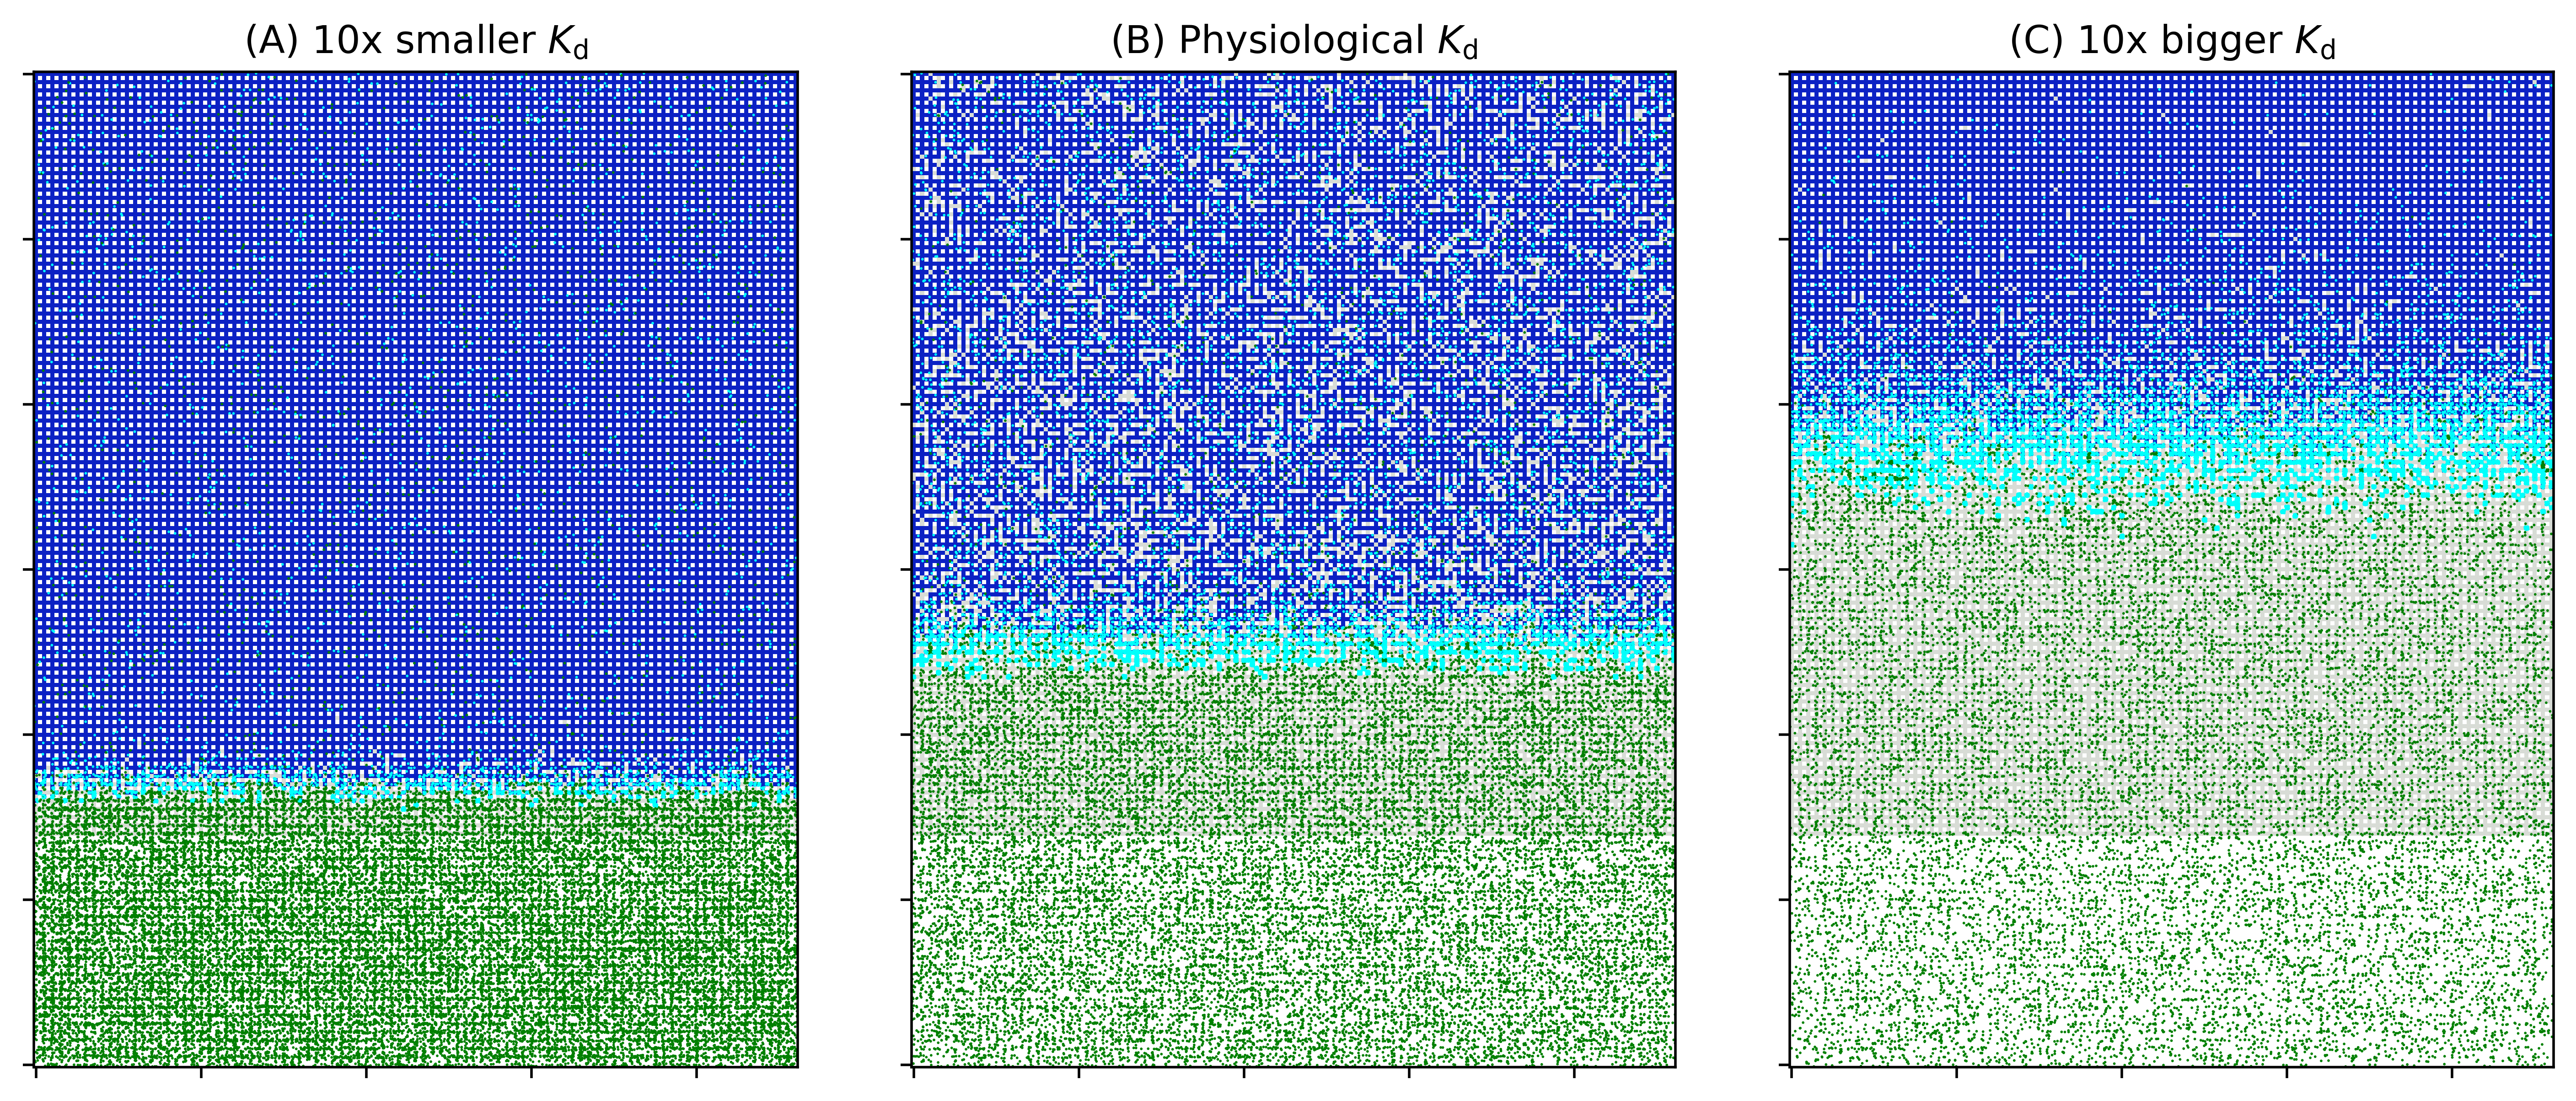

In [17]:
letters = ["(A)", "(B)", "(C)", "(D)"]
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(12, 9),
    dpi=500,
    # constrained_layout=True,
)
fig.tight_layout(pad=2.0)
mech = mechanisms[mechanisms["descriptor"] == "Diffuse into and along clot"][0]
for j, scen in enumerate(scenarios):
    exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
        "exp_code"
    ][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=exp_code)
    exp = e
    e.read_file()
    file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction)

    edge_index = get_edge_index(e)
    x_f, y_f, x_m, y_m = animation_data(e, file_code, edge_index, mol_location)
    y_f = -y_f
    y_m = [-y for y in y_m]

    sim = 0
    frame = 30

    # axs[subfigs[i]].set_axis_off()
    vmin = 0
    vmax = exp.macro_params.cols - 1

    ydiff = exp.macro_params.rows - exp.macro_params.cols

    axs[j].set_xlim(vmin - 0.25, vmax + 0.25)
    axs[j].set_ylim(-(-vmin + 0.25), -(-vmax - ydiff - 0.25))
    axs[j].set_aspect("equal")
    axs[j].set_title(f"{letters[j]} {scen['descriptor'][:-2]}" + r"$K_\mathrm{d}$")
    axs[j].tick_params(labelleft=False)
    axs[j].tick_params(labelbottom=False)

    # fig.canvas.draw()
    # title = axs[subfigs[i]].annotate(
    #     f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
    #     (0, 0),
    #     zorder=100,
    #     va="top",
    # )
    s = (axs[j].get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
    scatt_f = axs[j].scatter(
        x_f,
        y_f,
        s=s,
        marker="s",
        linewidths=0,
        c=deg[sim][frame],
        cmap=colormap_f,
        vmin=exp.macro_params.time_step,
        vmax=tsave[sim][frame],
    )
    scatt_m = axs[j].scatter(
        x_m[sim][frame],
        y_m[sim][frame],
        s=s / 2.5,
        marker="o",
        linewidths=0,
        c=mol_status[sim][frame],
        cmap=colormap_m,
        norm=norm_m,
    )
    fig.savefig("degradation_state_5min_into_and_along.png", bbox_inches="tight")
    print(f"{deg_fraction[sim][frame]:%}")

In [ ]:
letters = [["(A)", "(B)", "(C)"], ["(D)", "(E)", "(F)"], ["(G)", "(H)", "(I)"], ["(J)", "(K)", "(L)"]]
fig, axs = plt.subplots(
    nrows=4,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(11, 18),
    dpi=200,
    # constrained_layout=True,
)
fig.tight_layout(pad=2.0)
for i, mech in enumerate(mechanisms):
    for j, scen in enumerate(scenarios):
        exp_code = runs[(runs["scenario"] == scen["descriptor"]) & (runs["mechanism"] == mech["descriptor"])][
            "exp_code"
        ][0]
        e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=exp_code)
        exp = e
        e.read_file()
        file_code = out_file_code.format(data_code=scen["file_code"], mech_code=mech["file_code"])

        n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

        deg_fraction = find_degraded_fraction(e, deg, tsave)
        marker_frames = find_degradation_marker_frames(e, deg_fraction)

        edge_index = get_edge_index(e)
        x_f, y_f, x_m, y_m = animation_data(e, file_code, edge_index, mol_location)
        y_f = -y_f
        y_m = [-y for y in y_m]

        sim = 0
        frame = marker_frames[sim][3]

        # axs[subfigs[i]].set_axis_off()
        vmin = 0
        vmax = exp.macro_params.cols - 1

        ydiff = exp.macro_params.rows - exp.macro_params.cols

        axs[i, j].set_xlim(vmin - 0.25, vmax + 0.25)
        axs[i, j].set_ylim(-(-vmin + 0.25), -(-vmax - ydiff - 0.25))
        axs[i, j].set_aspect("equal")
        if i == 3:
            axs[i, j].set_xlabel(
                scen["descriptor"][:-2] + r"$K_\mathrm{d}$",
                fontsize=16,
            )
        if j == 0:
            axs[i, j].set_ylabel(
                mech["descriptor"],
                fontsize=16,
            )
        axs[i, j].set_title(
            f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
            fontsize=8,
        )
        axs[i, j].tick_params(labelleft=False)
        axs[i, j].tick_params(labelbottom=False)

        # fig.canvas.draw()
        # title = axs[subfigs[i]].annotate(
        #     f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
        #     (0, 0),
        #     zorder=100,
        #     va="top",
        # )
        s = (axs[i, j].get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
        scatt_f = axs[i, j].scatter(
            x_f,
            y_f,
            s=s,
            marker="s",
            linewidths=0,
            c=deg[sim][frame],
            cmap=colormap_f,
            vmin=exp.macro_params.time_step,
            vmax=tsave[sim][frame],
        )
        scatt_m = axs[i, j].scatter(
            x_m[sim][frame],
            y_m[sim][frame],
            s=s / 2.5,
            marker="o",
            linewidths=0,
            c=mol_status[sim][frame],
            cmap=colormap_m,
            norm=norm_m,
        )
        print(f"{tsave[sim][frame]} sec")

fig.savefig("degradation_state_all_0.80.png", bbox_inches="tight")